In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [3]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)
print(dir(ma))

['MO', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'array_summary', 'cos_sim', 'datetime', 'get_diagonal', 'get_diagonal_prob', 'get_mondays', 'get_travelling_out', 'h5py', 'h5py_to_4d_array', 'np', 'pd', 'region_mobility', 'region_out_desitination', 'relativedelta', 'relave_diff_D', 'test', 'timedelta']


In [4]:
# Load the data
Ms_h_base = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240909.h5')
Ms_h0 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240916.h5')
Ms_h = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240923.h5')
Ms_h1 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240930.h5')

In [5]:
cut_off_ls = [10, 20, 50, 100, 150,200]
no_cut = len(cut_off_ls)
hrc_name = 'helene'
start_date = "2024-09-09"

In [6]:
# Read list back from the text file
no_wk = 4
WithinRegion = np.zeros((no_cut,2,no_wk*7))
OutRegion = np.zeros((no_cut,2,28))
FlowinRegion = np.zeros((no_cut,2,28))
NetOutRegion = np.zeros((no_cut,2,28))

for cutoff_id in range(no_cut):
    cutoff_mile = cut_off_ls[cutoff_id]
    print(cutoff_mile)
    with open("../results/helene/counties_geoid_cut_{}.txt".format(cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]

    county_list = [int(x) for x in county_list]
    geo_idx = pd.read_csv('geoid_idx_names.csv')
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values

    M_base, MOut_base, MIn_base = ma.region_mobility(Ms_h_base, selected_idx)
    M0, MOut0, MIn0 = ma.region_mobility(Ms_h0,selected_idx)
    M, MOut, MIn = ma.region_mobility(Ms_h,selected_idx)
    M1, MOut1, MIn1 = ma.region_mobility(Ms_h1,selected_idx)

    M_all = np.concatenate([M_base, M0, M, M1], axis=0)
    MOut_all = np.concatenate([MOut_base, MOut0, MOut, MOut1], axis=0)
    MIn_all = np.concatenate([MIn_base, MIn0, MIn, MIn1], axis=0)

    V_all = np.sum(M_all, axis=1) ### within region
    VOut_all = np.sum(MOut_all, axis=1) ### out region excluding the selected region
    VIn_all = np.sum(MIn_all, axis=1) ### in region excluding the selected region

    v_incounty = V_all.sum(axis=1)
    base = np.tile(v_incounty[:7],4)
    WithinRegion[cutoff_id,0,:] = v_incounty
    WithinRegion[cutoff_id,1,:] = base
    
    v_outcounty = VOut_all.sum(axis=1)
    base_out = np.tile(v_outcounty[:7],4)
    OutRegion[cutoff_id,0,:] = v_outcounty
    OutRegion[cutoff_id,1,:] = base_out

    v_flowin = VIn_all.sum(axis=1)
    base_flowin = np.tile(v_flowin[:7],4)
    FlowinRegion[cutoff_id,0,:] = v_flowin
    FlowinRegion[cutoff_id,1,:] = base_flowin

    v_netout = v_outcounty - v_flowin
    base_netout = np.tile(v_netout[:7],4)
    NetOutRegion[cutoff_id,0,:] = v_netout
    NetOutRegion[cutoff_id,1,:] = base_netout

10
20
50
100
150
200


In [7]:
WithinRegion_change = WithinRegion[:,0,7:] - WithinRegion[:,1,7:]
WithinRegion_relative_change = WithinRegion_change / WithinRegion[:,1,7:]

OutRegion_change = OutRegion[:,0,7:] - OutRegion[:,1,7:]
OutRegion_relative_change = OutRegion_change / OutRegion[:,1,7:]

In [8]:
mhp = reload(mhp)

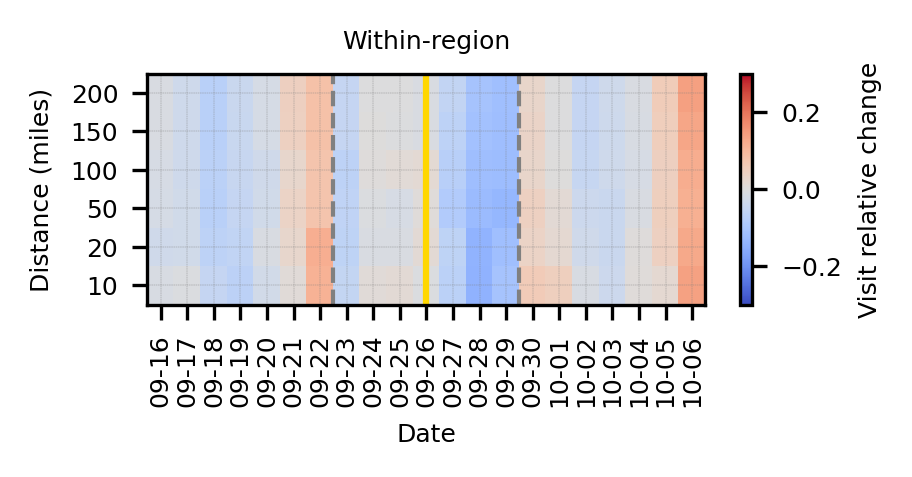

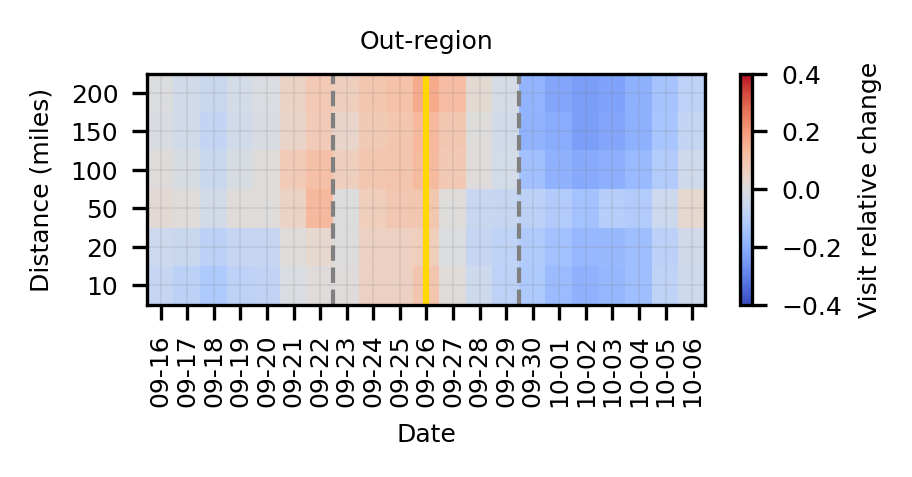

In [9]:
start_date_p = "2024-09-16"
dates_p = pd.date_range(start=start_date_p, periods=3*7, freq="D") 
highlight_date = pd.to_datetime("2024-09-26")
save_path = "../results/{}/".format(hrc_name)


# data = WithinRegion_change
# title = 'Helene Within-region Raw Visit Change'
# mhp.plot_heatmap(data, dates_p, cut_off_ls, highlight_date,title)

data = WithinRegion_relative_change
title = 'Within-region'
mhp.plot_heatmap(data, 0.3, dates_p, cut_off_ls, highlight_date,title,save_path)


# data = OutRegion_change
# title = 'Helene Out-region Raw Visit Change'
# mhp.plot_heatmap(data, dates_p, cut_off_ls, highlight_date,title)

data = OutRegion_relative_change
title = 'Out-region'
mhp.plot_heatmap(data, 0.4, dates_p, cut_off_ls, highlight_date,title,save_path)

In [8]:
WithinRegion_relative_change.shape

(6, 21)

In [18]:
data = OutRegion_relative_change[2,7:10] ## three days before the landfall
print (np.mean(data)*100)

data = OutRegion_relative_change[2,10:14] ## three days before the landfall
print (np.mean(data)*100)

data = OutRegion_relative_change[2,14:] ## three days before the landfall
print (data.shape, np.mean(data)*100)

# print (np.median(OutRegion_relative_change[:,9])*100)
# q1 = np.percentile(data, 25)  # 25th percentile (Q1)
# q3 = np.percentile(data, 75)  # 75th percentile (Q3)

# print(f"25th percentile (Q1): {q1}")
# print(f"75th percentile (Q3): {q3}")

5.0816882358093345
-0.7004272514866468
(7,) -8.34319738761843


In [20]:
data = WithinRegion_relative_change[2,7:10]
print(np.mean(data)*100)

data = WithinRegion_relative_change[2,10:14] ## not include the landfall day
print(np.mean(data)*100)

# print(np.median(WithinRegion_relative_change[:,9])*100)
# q1 = np.percentile(data, 25)*100  # 25th percentile (Q1)
# q3 = np.percentile(data, 75)*100  # 75th percentile (Q3)

# print(f"25th percentile (Q1): {q1}")
# print(f"75th percentile (Q3): {q3}")

-2.7800177852726886
-8.447198827976512
